In [4]:
import networkx as nx
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('axes', axisbelow=True)

# Introduction to Network Resilience

...from **Resilience and evolvability of protein-protein interaction networks**, by Brennan Klein, Ludvig Holmér, Keith M. Smith, Mackenzie M. Johnson, Anshuman Swain, Laura Stolp, Ashley I. Teufel, and April S. Kleppe (2020):

#### Modified Shannon diversity
The *network resilience*, $R$, is an information theoretic measure that describes the extent to which random node removal deteriorates network structure (**[Zitnik et al., 2019](https://www.pnas.org/content/116/10/4426)**). It is computed by iteratively removing a fraction, $f$, of the nodes in the network and calculating a modified Shannon diversity measure for the resulting network. For a network of size $N$, this is:
$$H_{msh}(G) = -\dfrac{1}{\log(N)} \displaystyle \sum_{x = 1}^{X} p_{x} \log p_{x}$$
where $p_{x} = \frac{|c_{x}|}{N}$ and $c_{x}$ is a connected component; $p_{x}$, therefore, is the probability that a randomly selected node is in the connected component $c_{x}$.

#### Network resilience
The resilience of a network, $G$, is computed by iteratively removing a fraction, $f$, of nodes in the network (each time, this creates at least one new disconnected component, $c_x$, of size $|c_x|=1$). As $f$ increases from $0$ to $1$, the network becomes more and more disconnected until $f=1$, at which point the resulting network, $G_{f=1}$, is a collection of $N$ disconnected nodes. The Shannon diversity of these component size distributions increases as $f$ increases. The final value for resilience is then calculated as the area under this curve:
$$R(G) = 1 - \displaystyle\sum_{f=0}^{1} \dfrac{H_{msh}(G_f)}{r_f}$$
where $r_f$ is the number of $f$ values (i.e, if $r_f=100$, we remove 1\%, 2\%, ... 100\% of the nodes) and $H_{msh}(G_f)$ is the modified Shannon diversity of the network after $f$ fraction of nodes have been disconnected. Dense Erdös-Rényi networks are more resilient than sparse ones, which conforms to the intuition that a complete network is the most resilient network, with a value $R(G)=0.5$.

The following two code blocks define functions for calculating the modified shannon entropy and resilience.

In [2]:
def modified_shannon_entropy(G, f, removal='random',
                             niter=50, return_stdv=False):
    """
    After a fraction, f, nodes have been 'removed' from the network (i.e., they
    have become disconnected isolates, such that the number of nodes does not
    change), this measure corresponds to the entropy of the distribution of
    component sizes, P(C). That is, P(c_i) corresponds to the probability that
    a randomly selected node will be in component c_i; there is a higher
    probability that a randomly-selected node will be in larger components.

    Parameters
    ----------
    G (nx.Graph):
        the graph in question.

    f (float):
        the fraction of N nodes in the network to be removed.

    removal (str):
        the method by which nodes are removed from the network.

    ntimes (int):
        the number of times to remove nodes to compute the mean entropy.

    return_stdv (bool):
        if True, this function returns a mean entropy as well as the standard
        deviation of the entropy after running ntimes. if False, this function
        just returns the mean value for the entropy.

    Returns
    -------
    H_msh_mean (float):
        the modified Shannon entropy averaged over ntimes runs. if return_stdv,
        this function also returns H_msh_stdv.

    """
    H_msh_mean = []
    for _ in range(niter):
        out_H = []
        N = G.number_of_nodes()
        leading_term = -1 / np.log2(N)
        p_i_unif = 1 / N

        G_f = G.copy()

        if removal == 'random':
            remove_nodes = [i for i in G_f.nodes() if np.random.rand() < f]

        else:
            warnings.warn("Only implemented for *random*. switching to that.")
            remove_nodes = [i for i in G_f.nodes() if np.random.rand() < f]

        curr = 0

        if len(remove_nodes):
            for node_r in remove_nodes:
                G_f.remove_node(node_r)
                curr += p_i_unif * np.log2(p_i_unif)

        Cs = list(nx.connected_components(G_f))
        for Ci in Cs:
            p_i = len(Ci) / N
            curr += p_i * np.log2(p_i)

        out_H.append(curr)

        H_msh = np.abs(leading_term * np.sum(out_H))
        H_msh_mean.append(H_msh)

    if return_stdv and niter > 4:

        return np.array(H_msh_mean).mean(), np.array(H_msh_mean).std()

    else:
        return np.array(H_msh_mean).mean()

In [6]:
def resilience(G, ntimes=10, rate=50, output_list=True, removal='random',
               H_std=True, niter=50):
    """
    The resilience of a network, G, is defined as the Shannon
    entropy of the cluster size distribution of a graph at a given
    time, t. By repeatedly removing a fraction of random nodes at each
    timestep, we observe the change of this distribution and, as such
    the entropy, H_sh. The resilience is calculated as the 1-sum(H_sh).

    Parameters
    ----------
    G (nx.Graph):
        the graph in question.

    n_times (int):
        the number of runs that the algorithm goes through in order to arrive
        at the final (averaged) entropy value.

    rate (int):
        the number of intervals between 0 and 1, which correspond to fractions
        of the network that are removed at each step.

    output_list (bool):
        if True, returns a list of resilience values. else, returns one value.
.
    removal (str):
        method of node-removal. for now this only includes 'random', but one
        can imagine a number of ways to systematically bias the node-removal
        process (e.g. based preferentially on degree, etc.)

    Returns
    -------
    out_mean (list or float):
        if output_list==True, this function returns a list of length = rate
        entropy values, which forms the curve that is used to calculate the
        network resilience. else, it returns 1 - sum(out_mean)/rate.

    """

    out_mean = []
    out_stdv = []
    for _ in range(ntimes):
        H_out_mean = []
        H_out_stdv = []
        for f in np.linspace(0, 1, rate):
            H_msh_mean, H_msh_stdv = modified_shannon_entropy(G, f, removal,
                                                              niter, H_std)
            H_out_mean.append(H_msh_mean)
            H_out_stdv.append(H_msh_stdv)

        out_mean.append(np.array(H_out_mean))
        out_stdv.append(np.array(H_out_stdv))

    out_mean = np.array(out_mean).mean(axis=0)
    out_stdv = np.array(out_stdv).mean(axis=0)

    if output_list:
        return out_mean

    else:
        return 1 - sum(out_mean) / rate

First, create three graphs $G_1, G_2$ and $G_3$ that correspond to the Karate Club, an Erdos-Renyi graph and a Barabasi Albert graph with the same number of nodes and density.

In [9]:
G1 = nx.karate_club_graph()
G2 = nx.erdos_renyi_graph(G1.number_of_nodes(),nx.density(G1))
G3 = nx.barabasi_albert_graph(G1.number_of_nodes(),int(nx.density(G1)*G1.number_of_nodes()/2))

The following code can be used to calculate and plot the resilience of each of the graphs -- complete it by filling in lines 14-16 with the appropriate
functions.

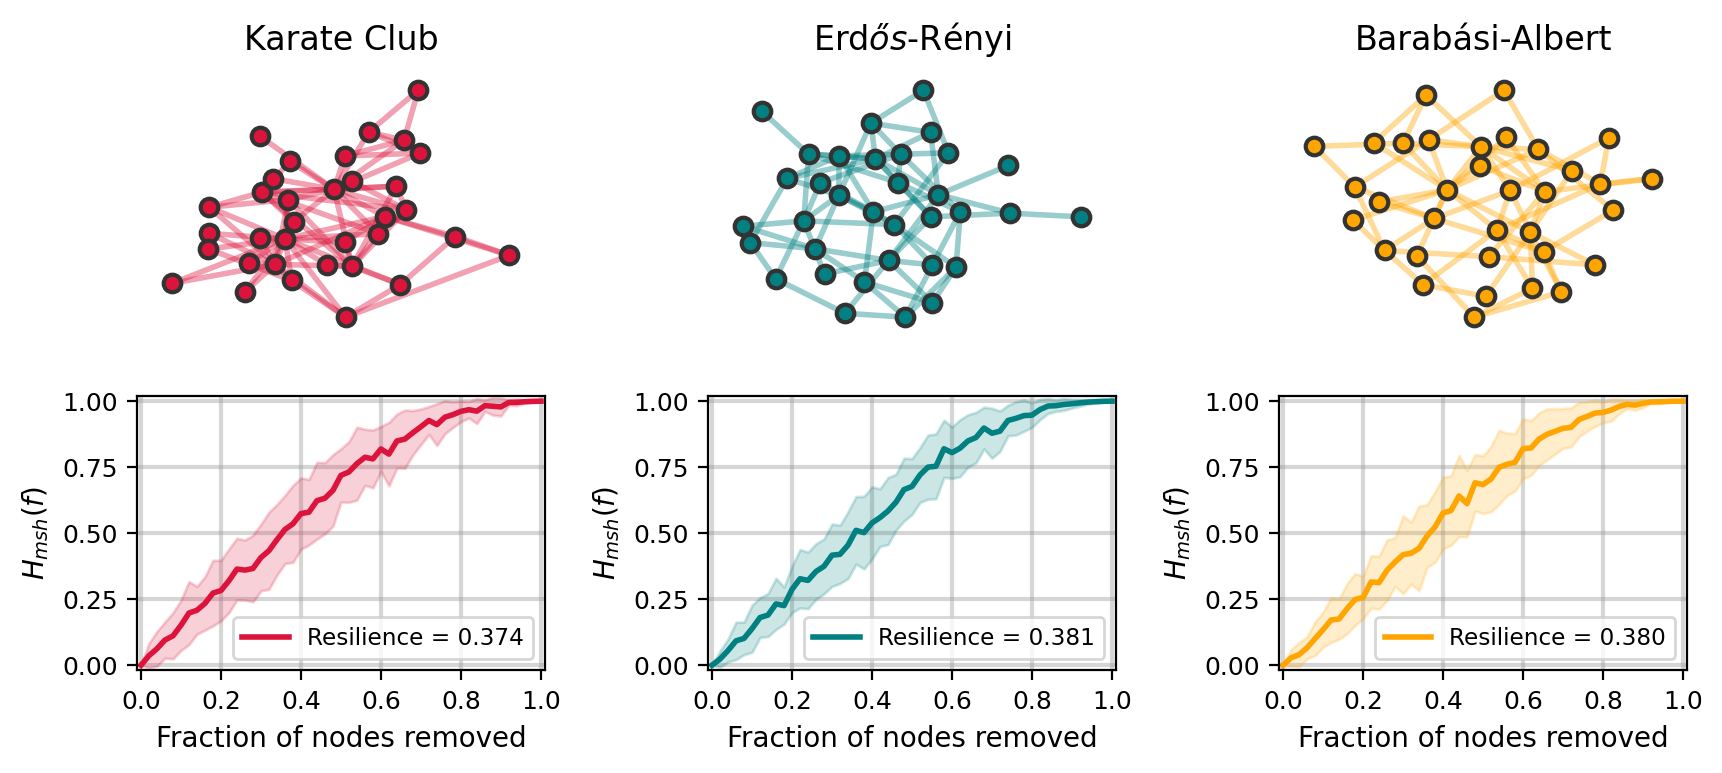

In [8]:
rate = 51
rates = np.linspace(0, 1, rate)
graphs = [G1, G2, G3]
cols = ['crimson', 'teal', 'orange']
titles = ['Karate Club', r'Erd$o\H{s}$-Rényi', 'Barabási-Albert']

fig, ax = plt.subplots(2, 3, figsize=(10,4), dpi=200)
plt.subplots_adjust(wspace=0.4, hspace=0.2)

for i, Gi in enumerate(graphs):
    Hout_m = []
    Hout_s = []
    for f in rates:
        # Hsm, Hss = modified_shannon_entropy(Gi, f, removal='random', return_stdv=True)
        # Hout_m.append(Hsm)
        # Hout_s.append(Hss)

    means = np.array(Hout_m)
    stdvs = np.array(Hout_s)
    
    res = 1 - sum(means) / rate
    ax[(1,i)].plot(rates, means, color=cols[i],
                   linewidth=2, label='Resilience = %.3f'%res)
    ax[(1,i)].fill_between(rates, means-stdvs, means+stdvs,
                           alpha=0.2, color=cols[i])
    
    ax[(1,i)].set_xlabel('Fraction of nodes removed')
    ax[(1,i)].set_xticks(np.linspace(0,1,6).round(2))
    ax[(1,i)].set_xlim(-0.01,1.01) 

    ax[(1,i)].set_ylabel(r'$H_{msh}(f)$')
    ax[(1,i)].set_yticks(np.linspace(0,1,5).round(2))
    ax[(1,i)].set_ylim(-0.02,1.02) 

    ax[(1,i)].grid(color='#999999', linewidth=1.5, alpha=0.4)
    ax[(1,i)].legend(fontsize='small')

    pos = nx.kamada_kawai_layout(Gi)
    nx.draw_networkx_nodes(Gi, pos, ax=ax[(0,i)], node_size=40, linewidths=1.5,
                           node_color=cols[i], edgecolors='#333333')
    nx.draw_networkx_edges(Gi, pos, ax=ax[(0,i)], edge_color=cols[i],
                           alpha=0.4, width=2)
    ax[(0,i)].set_title(titles[i])
    ax[(0,i)].set_axis_off()

for qi,a in enumerate(fig.axes):
    a.tick_params(axis='both', bottom=True, labelsize=9,
                  labelbottom=True, left=True, labelleft=True)

plt.show()

# Protein networks

from [**Resilience and evolvability of protein-protein interaction networks**. by Brennan Klein, Ludvig Holmér, Keith M. Smith, Mackenzie M. Johnson, Anshuman Swain, Laura Stolp, Ashley I. Teufel, and April S. Kleppe. (2020)]().

In this work, we study the resilience and prospective resilience of three ribosomal protein networks: *S. cerevisiae*, *E. coli*, and *H. sapiens*. Each ribosomal protein of a given species is represented by a node in the network. The links between nodes were then established wherever there was evidence of protein-protein interactions in that species, in this case based on data from the SNAP database. We extracted the ribosomal proteins from the network data in Zitnik et al. (2019) and constructed individual ribosomal protein subnetworks based on data from the KEGG database.

In [11]:
G_yeast = nx.read_graphml('./data/G_sce.graphml')
G_ecoli = nx.read_graphml('./data/G_eco.graphml')
G_human = nx.read_graphml('./data/G_hsa.graphml')

In [13]:
from presilience import *

Fill in lines 16-17 to calculate the presilience of each of the networks.

In [ ]:
niter = 6
t_out = 10
r_out = 20
ms = [4,8,16]

graph_dict = {'G_yeast':G_yeast, 'G_ecoli':G_ecoli, 'G_human':G_human}

out_dict = {'G_yeast':{m_i:[] for m_i in ms},
            'G_ecoli':{m_i:[] for m_i in ms},
            'G_human':{m_i:[] for m_i in ms}}

for Gname in out_dict.keys():
    Gx = graph_dict[Gname]
    for m_i in ms:
        print(Gname, "%02i"%m_i, dt.datetime.now())
        # p_i = presilience(G_ecoli, t=t_out, m=m_i, ntimes=niter, rate=r_out, printt=False)
        # out_dict[Gname][m_i] = p_i

The following code can be used to plot the graph of presilience against nodes added.

In [ ]:
titles = {'G_yeast':r"$\bf{S. cerevisiae}$"+"\nprotein interaction network",
          'G_ecoli':r"$\bf{E. coli}$"+"\nprotein interaction network",
          'G_human':r"$\bf{H. sapiens}$"+"\nprotein interaction network"}

axes = {'G_yeast':0, 'G_ecoli':1, 'G_human':2}

cols = plt.cm.viridis(np.linspace(0.05,0.95,len(ms)))
cols = dict(zip(ms,cols))

fig, ax = plt.subplots(1, 3, figsize=(15,4), dpi=200, sharey=True)
plt.subplots_adjust(hspace=0.015, wspace=0.1)

for Gname, m_data in out_dict.items():
    a = axes[Gname]
    for m_i in m_data.keys():
        ax[a].plot(range(t_out+1), m_data[m_i][1], linewidth=3,
                   color=cols[m_i], label='m = %i (random attachment)'%m_i)

    
    ax[a].grid(linestyle='-', linewidth=2, alpha=0.25, color='#999999')
    ax[a].set_xlabel("Number of nodes added", fontsize=16)
    ax[a].set_xticks(np.linspace(0, 10, 6))
    ax[a].set_xticklabels(np.linspace(0, 10, 6,dtype=int))
    ax[a].set_xlim(-0.25,10.25)
    ax[a].tick_params(axis='both', which='major', labelsize=12)
    
    ax[a].legend(fontsize='small')
    ax[a].set_title(titles[Gname],fontsize=17)    

    
alphabet = ['A', 'B', 'C']
for ai, a in enumerate(fig.axes):
    a.text(-0.035, 1.1, alphabet[ai], fontsize=20, horizontalalignment='center',
           verticalalignment='center', transform=a.transAxes, fontweight='bold')

ax[0].set_ylabel("Resilience", fontsize=17, labelpad=10)
plt.show()